In [ ]:
#import all libraries you need here
import pandas as pd
import numpy as np
import pathlib as pl
import scanpy as sc
import scipy
import anndata as ad
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score, v_measure_score
from scipy.stats import spearmanr

# Step 0: Download the data

In [2]:
path_data = pl.Path(".")
all_bulkified = pd.read_csv(path_data /"train_data/train_bulk.csv",index_col=0)
train_adata = sc.read_h5ad(path_data /"train_data/train_adata.h5ad")

In [3]:
print(f"Number of patients to deconvolve: {all_bulkified.shape[1]}")
print(f"Number of genes in dataset: {all_bulkified.shape[0]}")

Number of patients to deconvolve: 12
Number of genes in dataset: 7725


In [4]:
print(f"Number of cells in the train set {train_adata.n_obs}")
for spl in train_adata.obs.Sample.unique():
    print(f"Number of cells for {spl} is {train_adata[train_adata.obs.Sample==spl].n_obs}")

Number of cells in the train set 32374
Number of cells for s1 is 6821
Number of cells for s2 is 4555
Number of cells for s3 is 5166
Number of cells for s4 is 5607
Number of cells for s7 is 4471
Number of cells for s8 is 5754


In [5]:
print(f"There are {train_adata.obs.highLevelType.nunique()} different cell types in the dataset")
print(f"The different cells types are {train_adata.obs.highLevelType.unique().astype(str)}")

There are 9 different cell types in the dataset
The different cells types are ['T' 'B' 'Plasmablast' 'Fibroblast' 'Mast' 'Myeloid' 'NK' 'Myofibroblast'
 'Endothelial']


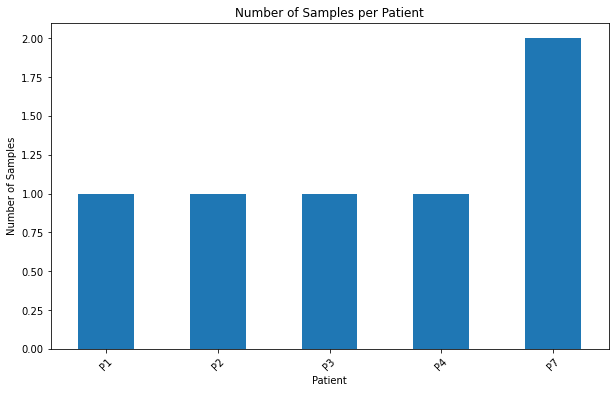

In [6]:
# Plotting  the number of samples per patient to check for replicates and resonable variables to batch correct for
patient_sample_counts = train_adata.obs.groupby('Patient')['Sample'].nunique()
plt.figure(figsize=(10, 6))
patient_sample_counts.plot(kind='bar', title="Number of Samples per Patient")
plt.ylabel("Number of Samples")
plt.xlabel("Patient")
plt.xticks(rotation=45)
plt.show()

/root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


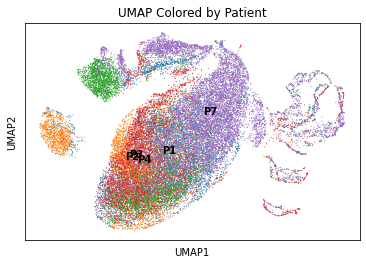

/root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


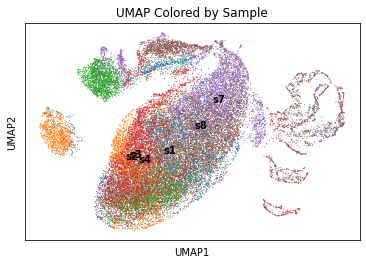

/root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


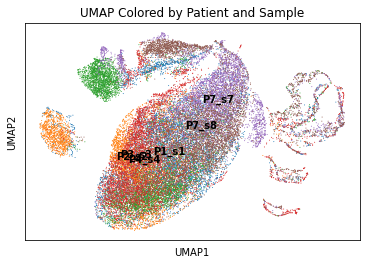

In [10]:
# Check if samples for different patients cluster together
sc.pp.pca(train_adata)
sc.pp.neighbors(train_adata, n_neighbors=10)
sc.tl.umap(train_adata)

#Generating UMAPs to check data clustering by sample and patient
sc.pl.umap(train_adata, color='Patient', title="UMAP Colored by Patient", legend_loc='on data') #Colored by Patient
sc.pl.umap(train_adata, color='Sample', title="UMAP Colored by Sample", legend_loc='on data') #Colored by Sample

#Now the combination
train_adata.obs['Patient_Sample'] = train_adata.obs['Patient'].astype(str) + '_' + train_adata.obs['Sample'].astype(str)
sc.pl.umap(train_adata, color='Patient_Sample', title="UMAP Colored by Patient and Sample", legend_loc='on data')  #Colored by Patient and sample

/root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


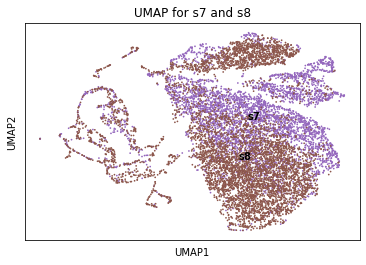

Correlation between s7 and s8 gene expression profiles: 0.96


In [ ]:
samples_subset = train_adata[train_adata.obs['Sample'].isin(['s7', 's8'])]

# 1. PCA and UMAP to visualize clustering
sc.pp.pca(samples_subset)
sc.pp.neighbors(samples_subset, n_neighbors=5)
sc.tl.umap(samples_subset)

# Plot UMAP for the subset
sc.pl.umap(samples_subset, color='Sample', title="UMAP for s7 and s8", legend_loc='on data')

# 2. Correlation Analysis
# Extract raw gene expression data
s7_data = samples_subset[samples_subset.obs['Sample'] == 's7'].X.toarray()
s8_data = samples_subset[samples_subset.obs['Sample'] == 's8'].X.toarray()

# Compute correlation between the average gene expression of the two samples

s7_mean = np.mean(s7_data, axis=0)
s8_mean = np.mean(s8_data, axis=0)

correlation = np.corrcoef(s7_mean, s8_mean)[0, 1]
print(f"Correlation between s7 and s8 gene expression profiles: {correlation:.2f}")

In [12]:
# Subset samples for s7 and s8
s7_data = train_adata[train_adata.obs['Sample'] == 's7'].X.toarray()
s8_data = train_adata[train_adata.obs['Sample'] == 's8'].X.toarray()

# Calculate mean gene expression and obtain a correlation dataframe by itarating over all the training samples
s7_mean = np.mean(s7_data, axis=0)
s8_mean = np.mean(s8_data, axis=0)

correlations = {}

for sample in ['s1', 's2', 's3', 's4', 's7', 's8']:
    sample_data = train_adata[train_adata.obs['Sample'] == sample].X.toarray()
    sample_mean = np.mean(sample_data, axis=0)
    
    corr_s7, _ = spearmanr(sample_mean, s7_mean)
    corr_s8, _ = spearmanr(sample_mean, s8_mean)
    
    correlations[sample] = {'Spearman Correlation with s7': corr_s7, 'Spearman Correlation with s8': corr_s8}

correlation_df = pd.DataFrame.from_dict(correlations, orient='index')
correlation_df 

,Spearman Correlation with s7,Spearman Correlation with s8
s1,0.802866,0.847182
s2,0.686859,0.770232
s3,0.767626,0.640034
s4,0.764672,0.866279
s7,1.000000,0.822877
s8,0.822877,1.000000


The training data contains 6 samples from 5 different patients. Only samples s7 and s8 belong to the same patient. The Spearman correlation between sample s7 and s8 is 0.822. However, correlation for s1 and s8 is higher (0.84). s7 and s8 do not seem to be biological replicates. Therefore, we batch correct for samples and not for patient.

# Step 1: Deconvolve the data

## Preprocessing of training data

In [7]:
#rename highLevelType to cell_types for scanden 
train_adata.obs.rename(columns={"highLevelType": "cell_types"}, inplace=True)

# Convert training data to dense matrix for scaden to work 
if scipy.sparse.issparse(train_adata.X):
    train_adata.X = train_adata.X.toarray()
train_adata.write("train_data/modified_dense_data.h5ad")

In [9]:

# Preprocess training data: filter genes, cells, mitochondrial gene count, normalizing, log-transforming and scaling 
sc.pp.filter_genes(train_adata, min_cells=80)
train_adata = train_adata[(train_adata.obs['n_genes'] > 200) & (train_adata.obs['n_genes'] < 2500)]
sc.pp.filter_cells(train_adata, min_genes=200)  
sc.pp.filter_cells(train_adata, max_genes=2500) 
train_adata = train_adata[train_adata.obs['pct_counts_mt'] < 5] 
sc.pp.normalize_total(train_adata)
sc.pp.log1p(train_adata)
sc.pp.scale(train_adata)

train_adata.write("train_data/processed_train.h5ad")
print("Normalized .h5ad file saved as 'processed_train.h5ad'.")


/root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Normalized .h5ad file saved as 'processed_train.h5ad'.


In [10]:
train_adata = ad.read_h5ad("train_data/processed_train.h5ad")
# add cell types manually to scanden 
if 'cell_types' in train_adata.obs.columns:
    train_adata.uns['cell_types'] = list(train_adata.obs['cell_types'].unique())
else:
    raise KeyError("Cell type information is missing.")



# One-hot encode cell types for scanden 
cell_types_onehot = pd.get_dummies(train_adata.obs['cell_types'])
train_adata.obs = train_adata.obs.join(cell_types_onehot)
train_adata.write_h5ad("final_processed_train.h5ad")

print(train_adata.obs.head())




                     Sample Patient Tumor status  n_genes  n_genes_by_counts  \
AAACCCAGTAGACAGC-1_1     s1      P1        Tumor     1013               1063   
AAACCCAGTAGATCGG-1_1     s1      P1        Tumor      807                855   
AAACCCAGTTGGAGGT-1_1     s1      P1        Tumor      918                958   
AAACGAAAGCCAAGCA-1_1     s1      P1        Tumor     1845               2028   
AAACGAAAGCGTGTTT-1_1     s1      P1        Tumor     1315               1414   

                      total_counts  total_counts_mt  pct_counts_mt  \
AAACCCAGTAGACAGC-1_1        2485.0             84.0       3.380282   
AAACCCAGTAGATCGG-1_1        1993.0             87.0       4.365278   
AAACCCAGTTGGAGGT-1_1        2438.0            108.0       4.429861   
AAACGAAAGCCAAGCA-1_1       17436.0            112.0       0.642349   
AAACGAAAGCGTGTTT-1_1       19905.0            239.0       1.200703   

                       cell_types chemo      B  Endothelial  Fibroblast  \
AAACCCAGTAGACAGC-1_1   

In [27]:
# preprocessing the predicition data 
data = pd.read_csv("train_data/train_bulk.csv", index_col=0)
cpm = data.div(data.sum(axis=0), axis=1) * 1e6

log_cpm = np.log2(cpm + 100)
log_cpm.to_csv("train_bulk_log_cpm.txt", sep='\t', index=True)

In [12]:
!scaden train final_processed_train.h5ad --steps 1000 --model_dir model_final


     ____                _            
    / ___|  ___ __ _  __| | ___ _ __  
    \___ \ / __/ _` |/ _` |/ _ \ '_ \ 
     ___) | (_| (_| | (_| |  __/ | | |
    |____/ \___\__,_|\__,_|\___|_| |_|

    
INFO     Training M256 Model ...                                     ]8;id=377217;file:///root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scaden/train.py\train.py]8;;\:]8;id=308609;file:///root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scaden/train.py#54\54]8;;\
m256 Step: 999, Loss: 0.0000 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━
WARNING  Compiled the loaded model, but the compiled metrics ]8;id=619886;file:///root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/keras/src/saving/legacy/saving_utils.py\saving_utils.py]8;;\:]8;id=195864;file:///root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/keras/src/saving/legacy/saving_utils.py#359\359]8;;\
         have yet to be built. `model.compile_metrics` will   

In [28]:
!scaden predict --model_dir model_final train_bulk_log_cpm.txt --outname pred_eval.txt


     ____                _            
    / ___|  ___ __ _  __| | ___ _ __  
    \___ \ / __/ _` |/ _` |/ _ \ '_ \ 
     ___) | (_| (_| | (_| |  __/ | | |
    |____/ \___\__,_|\__,_|\___|_| |_|

    
INFO     Loaded pre-trained model: m256                            ]8;id=888829;file:///root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scaden/model/scaden.py\scaden.py]8;;\:]8;id=8107;file:///root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scaden/model/scaden.py#280\280]8;;\
1/1 [==============================] - 0s 493ms/step
INFO     Loaded pre-trained model: m512                            ]8;id=395065;file:///root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scaden/model/scaden.py\scaden.py]8;;\:]8;id=178401;file:///root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scaden/model/scaden.py#280\280]8;;\
1/1 [==============================] - 0s 132ms/step
INFO     Loaded pre-trained model: m1024                    

In [29]:
# evaluate 
scaden_predictions = pd.read_csv("pred_eval.txt", sep="\t")
true_props = pd.read_csv("train_data/train_bulk_trueprops.csv")
true_props = true_props.set_index('highLevelType').T

scaden_predictions = scaden_predictions.set_index(scaden_predictions.columns[0])
scaden_predictions = scaden_predictions[true_props.columns] 
true_props = true_props.loc[scaden_predictions.index] 
rmse_per_cell_type = np.sqrt(((scaden_predictions - true_props) ** 2).mean(axis=0))
mean_rmse = rmse_per_cell_type.mean()

print("RMSE per cell type:")
print(rmse_per_cell_type)
print("\nMean RMSE across all cell types:", mean_rmse)

RMSE per cell type:
T                0.314582
Fibroblast       0.029586
NK               0.096559
Myeloid          0.066298
Mast             0.073984
B                0.056121
Myofibroblast    0.035806
Endothelial      0.069478
Plasmablast      0.043871
dtype: float64

Mean RMSE across all cell types: 0.08736502004445568


In [16]:
# generate final preds 

data = pd.read_csv("train_data/bulkified_data.csv", index_col=0)
cpm = data.div(data.sum(axis=0), axis=1) * 1e6

log_cpm = np.log2(cpm + 100)
log_cpm.to_csv("train_bulk_log_cpm_all.txt", sep='\t', index=True)

In [17]:
!scaden predict --model_dir model_final train_bulk_log_cpm_all.txt --outname pred_props.txt


     ____                _            
    / ___|  ___ __ _  __| | ___ _ __  
    \___ \ / __/ _` |/ _` |/ _ \ '_ \ 
     ___) | (_| (_| | (_| |  __/ | | |
    |____/ \___\__,_|\__,_|\___|_| |_|

    
INFO     Loaded pre-trained model: m256                            ]8;id=388680;file:///root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scaden/model/scaden.py\scaden.py]8;;\:]8;id=568984;file:///root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scaden/model/scaden.py#280\280]8;;\
1/1 [==============================] - 0s 209ms/step
INFO     Loaded pre-trained model: m512                            ]8;id=67453;file:///root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scaden/model/scaden.py\scaden.py]8;;\:]8;id=422786;file:///root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scaden/model/scaden.py#280\280]8;;\
1/1 [==============================] - 0s 265ms/step
INFO     Loaded pre-trained model: m1024                   

In [ ]:
# get the file in the desired shape 

file_path = "pred_props.txt" 
pred_props = pd.read_csv(file_path, sep='\t', index_col=0)
pred_props = pred_props.T
desired_order = ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
                 'NK', 'Myeloid', 'Mast']
pred_props = pred_props.loc[desired_order]
pred_props.insert(0, "index", pred_props.index)
output_file = "pred_props.csv"
pred_props.to_csv(output_file, index=False)

# Step 2: Perform clustering 

In [6]:
#Reload the dataset to get the raw data without preprocessing
train_adata = sc.read_h5ad(path_data / "train_data/train_adata.h5ad")

#Preprocessing the data
sc.pp.highly_variable_genes(train_adata, n_top_genes=4000, flavor="seurat_v3")
train_adata = train_adata[:, train_adata.var.highly_variable]  
sc.pp.normalize_total(train_adata)
sc.pp.log1p(train_adata)
sc.pp.scale(train_adata)

#Parameters for clustering
different_pc = [50] 
resolution_values = [0.03] 

for n_pc in different_pc:  #this was used for the iteration across possbile hyperparamter values
    for resolution in resolution_values:
        sc.tl.pca(train_adata, n_comps=n_pc, svd_solver='arpack')

        #Run batch correction with Harmony over the samples
        sc.external.pp.harmony_integrate(train_adata, "Sample") 

        sc.pp.neighbors(train_adata, use_rep='X_pca_harmony')
        
        sc.tl.leiden(train_adata,n_iterations=2, resolution=resolution) #Leiden clustering
        train_adata.obs['leiden'] = train_adata.obs['leiden'].astype(int) + 1 #Increment +1 the cluster labels to start from 1
        train_adata.obs['leiden'] = train_adata.obs['leiden'].astype(str) #Change the value type again for plotting
        
        cluster_labels = train_adata.obs['leiden']
        
        #Computing scores 
        true_labels = train_adata.obs['highLevelType']
        
        ari_score = adjusted_rand_score(true_labels, cluster_labels)
        v_measure = v_measure_score(true_labels, cluster_labels)
        cluster_score = 0.5 * (v_measure + ari_score)
        
        print(f'Number of PCs: {n_pc}, Resolution: {resolution}')
        print(f'Adjusted Rand Index (ARI): {ari_score:.4f}')
        print(f'V-measure Score: {v_measure:.4f}')
        print(f'Clustering Score: {cluster_score:.4f}')

/root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2024-12-03 19:10:12,532 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-03 19:11:03,788 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-03 19:11:04,262 - harmonypy - INFO - Iteration 1 of 10
2024-12-03 19:11:53,073 - harmonypy - INFO - Iteration 2 of 10
2024-12-03 19:12:37,078 - harmonypy - INFO - Iteration 3 of 10
2024-12-03 19:13:22,142 - harmonypy - INFO - Iteration 4 of 10
2024-12-03 19:14:08,745 - harmonypy - INFO - Iteration 5 of 10
2024-12-03 19:14:57,033 - harmonypy - INFO - Converged after 5 iterations


Number of PCs: 50, Resolution: 0.03
Adjusted Rand Index (ARI): 0.7911
V-measure Score: 0.8252
Clustering Score: 0.8082


In [ ]:
# Compute the neighborhood graph for PCA-embeddings 
sc.pp.neighbors(train_adata, use_rep='X_pca')
sc.tl.umap(train_adata)

# Plot Leiden clusters with UMAP
sc.pl.umap(train_adata, color=['leiden', 'highLevelType'], wspace=0.4, title=['Leiden Clusters', 'True Labels'])

# Step 2bis: Predict on the test data

In [7]:
# Use the same clustering technique to cluster the test data 
test_adata = sc.read_h5ad(path_data / "test_data/test_adata.h5ad")

#Preprocessing the data
sc.pp.highly_variable_genes(test_adata, n_top_genes=4000, flavor="seurat_v3")
test_adata = test_adata[:, test_adata.var.highly_variable]  
sc.pp.normalize_total(test_adata)
sc.pp.log1p(test_adata)
sc.pp.scale(test_adata)

#Parameters for clustering
different_pc = [50] 
resolution_values = [0.03] 

for n_pc in different_pc:  #this was used for the iteration across possbile hyperparamter values
    for resolution in resolution_values:
        sc.tl.pca(test_adata, n_comps=n_pc, svd_solver='arpack')

        #Run batch correction with Harmony over the samples
        sc.external.pp.harmony_integrate(test_adata, "Sample") 

        sc.pp.neighbors(test_adata, use_rep='X_pca_harmony')
        
        sc.tl.leiden(test_adata, n_iterations=2, resolution=resolution) #Leiden clustering
        test_adata.obs['leiden'] = test_adata.obs['leiden'].astype(int) + 1 #Increment +1 the cluster labels to start from 1
        test_adata.obs['leiden'] = test_adata.obs['leiden'].astype(str) #Change the value type again for plotting
        
        cluster_labels = test_adata.obs['leiden']

cluster_labels_df = cluster_labels.reset_index()
cluster_labels_df.columns = ["index", "cluster"]
cluster_labels_df


/root/miniconda3/envs/ml4g_project1/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2024-12-03 19:17:52,843 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-03 19:18:22,972 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-03 19:18:23,304 - harmonypy - INFO - Iteration 1 of 10
2024-12-03 19:18:45,782 - harmonypy - INFO - Iteration 2 of 10
2024-12-03 19:19:14,860 - harmonypy - INFO - Iteration 3 of 10
2024-12-03 19:20:01,284 - harmonypy - INFO - Iteration 4 of 10
2024-12-03 19:20:26,932 - harmonypy - INFO - Converged after 4 iterations


,index,cluster
0,AAACCCAAGGAGGCAG-1_5,1
1,AAACCCAAGTTGCGCC-1_5,1
2,AAACCCACACGGATCC-1_5,1
3,AAACCCACATCGGAAG-1_5,1
4,AAACCCAGTGCGAGTA-1_5,1
...,...,...
18611,TTTGGTTCATTGAAGA-1_10,1
18612,TTTGGTTGTTGTCCCT-1_10,4
18613,TTTGGTTGTTTGACAC-1_10,1
18614,TTTGTTGAGGGTCAAC-1_10,1


# Step 3: Save the required files

In [ ]:
# pred_props should be a DataFrame containing the estimated cell type proportions for the patients in all_bulkified
# pred_props.columns = ['index','s5_0','s5_1',...,'s10_3','s10_4'] = np.append(["index"],all_bulkified.columns)
# pred_props['index'] = ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
#       'NK', 'Myeloid', 'Mast']

In [ ]:
all_bulkified = pd.read_csv("train_data/bulkified_data.csv", index_col=0)
assert all(pred_props.columns == np.append(["index"],all_bulkified.columns)), "Wrong columns"

In [42]:
assert all(pred_props['index']== ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
       'NK', 'Myeloid', 'Mast']), "Wrong order for cell types"

In [43]:
assert all(pred_props.drop("index",axis=1).sum().round()==1), "The proportions for a single patient must sum to 1"

In [ ]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = test_adata.columns

In [8]:
assert all(cluster_labels_df.columns == ["index", "cluster"]), "Wrong columns"

In [9]:
assert all(cluster_labels_df["index"] == test_adata.obs_names), "The cell ids are either not all present or not in the right order"

In [10]:
pred_props_path = "pred_props.csv"
pred_props = pd.read_csv(pred_props_path)


import zipfile

archive_name = "Indilewitsch_Marie_Cardenal_Gonzalo_Project2.zip" 

with zipfile.ZipFile(archive_name, "x") as zf:
    with zf.open(f"pred_props.csv", "w") as buffer:
        pred_props.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels_df.to_csv(buffer)
    zf.close()